# XFeat matching example (sparse and semi-dense)

## First, clone repository

## Initialize XFeat

In [2]:
import numpy as np
import os
import torch
import tqdm
import cv2
import matplotlib.pyplot as plt
import sys
sys.path.append('/ws/src/model/enhancer/encoder/xFeat')

from xfeat import XFeat

xfeat = XFeat()

#Load some example images
im1 = cv2.imread('./test/ref.png')
im2 = cv2.imread('./test/tgt.png')

loading weights from: /ws/src/model/enhancer/encoder/xFeat/weights/xfeat.pt


## Simple function that fits an homography in a set of matches and draw the homography transform

In [13]:
import cv2
import numpy as np

def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    # corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], 
    # dtype=np.float32).reshape(-1, 1, 2)
    corners_img1 = np.array([[63, 63], [w-63, 63], [w-63, h-63], [63, h-63]], 
                            dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches


## Matching example - sparse setting

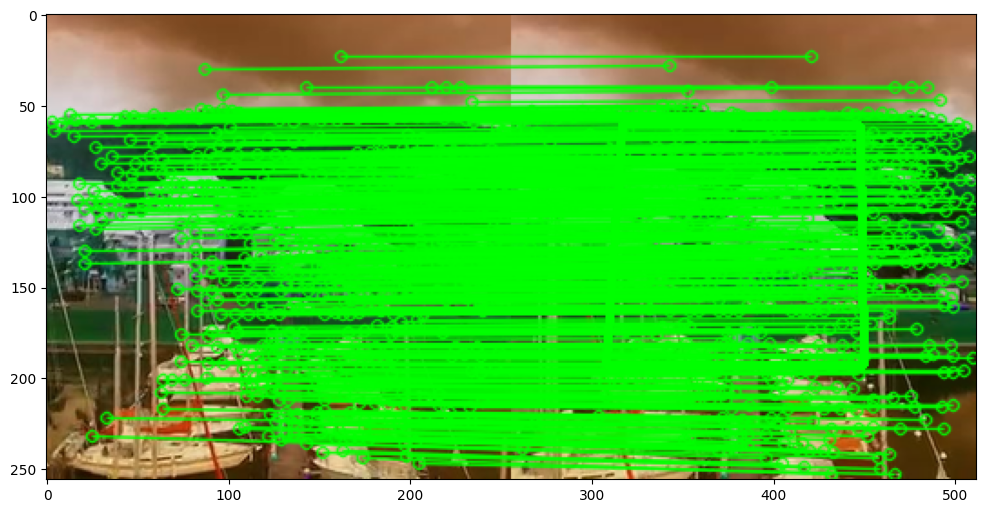

(<matplotlib.image.AxesImage at 0x7cf614308040>, None)

In [14]:
#Use out-of-the-box function for extraction + MNN matching
mkpts_0, mkpts_1 = xfeat.match_xfeat(im1, im2, top_k = 4096)

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()

## Matching example - Semi-dense setting

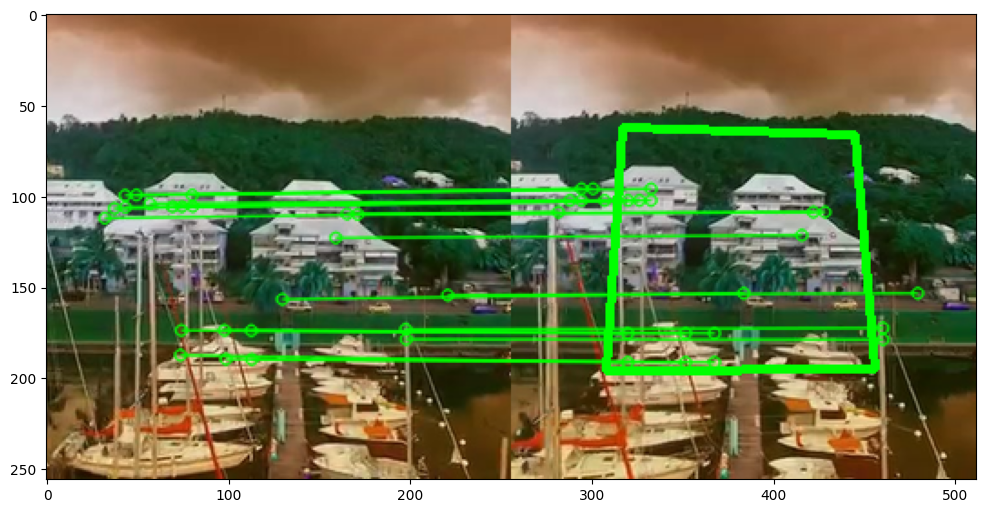

(<matplotlib.image.AxesImage at 0x7cf614349fc0>, None)

In [15]:
#Use out-of-the-box function for extraction + coarse-to-fine matching
mkpts_0, mkpts_1 = xfeat.match_xfeat_star(im1, im2, top_k = 100)

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()